<a href="https://colab.research.google.com/github/SergeiGrudinin/deeplearning-beginners/blob/master/notebook/Execrcise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks on MNIST

This notebook explains various approaches for implementing neural networks that recognize digits on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Originally copied from [ART.T458: Advanced Machine Learning](http://www.ocw.titech.ac.jp/index.php?module=General&action=T0300&GakubuCD=4&GakkaCD=342305&KeiCD=23&course=5&KougiCD=202004845&Nendo=2020&lang=EN&vid=03) course at [Tokyo Institute of Technology](https://www.titech.ac.jp/english/).

# Python basics
Below we will look at out first Python program (Notre premier programme python)

In [5]:
def do_something():
    return 0

def do_something_else(a):
    result = 0
    for i in a:
        # print(i,a[i])
        ...
    return result

if __name__ == '__main__':
    # do_something()
    my_dict = {"ke1":1, "key2":2, "key3":50, "key4":200}
    sum = do_something_else(my_dict)
    print("dictionary sum = ", sum)

dictionary sum =  0


<span style="color:SteelBlue"> Exercise 1</span> : modify the code such that the first function receives a list of elements and computes it sum
(modifier le code pour que la première fonction reçoive une liste d'éléments et calcule sa somme) :

`my_list = [1,2,3,4,5,6]`

`do_something(my_list)`

Also, print the type of the function input (Imprimez également le type d’entrée de fonction)

<span style="color:SteelBlue"> Exercise 2</span> : modify the code such that the second function receives a dictionary of elements and computes the sum of its values
(modifier le code de telle sorte que la deuxième fonction reçoive un dictionnaire d'éléments et calcule la somme de ses valeurs) :

`my_dict = {"ke1":1, "key2":2, "key3":50, "key4":200}`

`do_something_else(my_dict)`

Also, print the type of the function input (Imprimez également le type d’entrée de fonction)

## Preparing the MNIST dataset

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., `torchvision.datasets.MNIST` in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

The code below downloads the original distribution of the MNIST dataset on the Web, converts the dataset into `numpy` arrays, and saves the arrays as the file `mnist.npz` with keyword names.

In [6]:
import gzip
import sys
import struct
import urllib.request
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    # print(len(rawbuffer)) 
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/t10k-labels-idx1-ubyte.gz'))
    )

The file contains four numpy arrays (one tensor and array for each split of training and test sets) with the keywords:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


In [15]:
import numpy as np
data = np.load('mnist.npz')


# print(data['train_x'].shape, data['train_x'].dtype)
# print(data['train_y'].shape, data['train_y'].dtype)
# print(data['test_x'].shape, data['test_x'].dtype)
# print(data['test_y'].shape, data['test_y'].dtype)

print(data["train_x"][5][5:15][5:15], data["train_y"][5])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.70980394 0.9882353  0.9882353
  0.8627451  0.654902   0.11764706 0.         0.         0.3019608
  0.9882353  0.9882353  0.23529412 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.10196079 0.5019608  0.22745098
  0.08627451 0.         0.         0.         0.         0.39215687
  0.9882353  0.9882353  0.23529412 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.6156863
  0.9882353  0.9882353  0.23529412 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.     

<span style="color:SteelBlue"> Exercise 3</span> : print values of the 5th train image and its label (imprimer les valeurs de 5ème image 'train' et son étiquette)

<span style="color:SteelBlue"> Exercise 4</span> : print center pixels of the 5th train image, pixels from 5 to 15 only (imprimer les pixels centraux de la 5ème image, pixels de 5 à 15 uniquement)

## Visualize the dataset

2


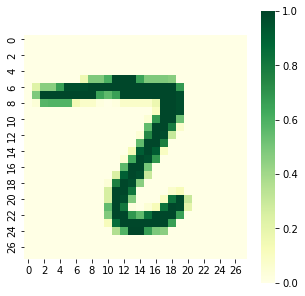

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).

data = np.load('mnist.npz')

i = 1

image = data['test_x'][i]
label = data['test_y'][i]

all_images = data['test_x']
all_images_rotated = np.rot90(all_images, 2, axes=(1,2))

image = all_images_rotated[1]
print(label)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(image, annot=False, fmt='.1f', square=True, cmap="YlGn")
plt.show()

small_training_set = data['train_x'][0:]

<span style="color:SteelBlue"> Exercise 5</span> : print images from 50 to 60 (imprimer des images de 50 à 60)

<span style="color:SteelBlue"> Exercise 6</span> : prepare a 'hard' test set with 90 degrees rotated images (préparer un ensemble de tests « durs » avec des images pivotées à 90 degrés)

<span style="color:SteelBlue"> Exercise 7</span> : prepare a 'small' training set with 10 times fewer images (préparer un « petit » ensemble de "train" avec 10 fois moins d’images)




In [58]:
s = int(data["train_x"].shape[0]/10)
print(s)
train_small = data["train_x"][0:s]


print(train_small.shape)
label_small = data["train_y"][0:s]
print(label_small.shape)


6000
(6000, 28, 28)
(6000,)


# Linear algebra basics
For the first model we will need two functions, 
- dot (inner) product between vectors, (produit scalaire entre les vecteurs)
- and argmax

<span style="color:SteelBlue"> Exercise 8</span> : write a dot product of two Python lists (écrire un produit scalaire de deux listes Python)

<span style="color:SteelBlue"> Exercise 9</span> : write a dot product of two numpy vectors (écrire un produit scalaire de deux vecteurs numpy)



In [20]:
import numpy as np

def dot_product(a,b):
    assert len(a) == len(b)
    dot = 0
    ... # exercise 8
    return dot


a = [1,2,3,4,5,6,7,8,9,10,12,23,34]
b = [2,3,4,5,6,7,8,9,10,11,10,-1,2]

print("dot (a,b) = ",dot_product(a,b))

#convert lists into numpy vectors
a_np = np.array(a)
b_np = np.array(b)

print(a_np, type(a_np), len(a_np), a_np.shape, a_np.transpose(), a_np.transpose().shape)


print("dot_np (a_np,b_np) = ",dot_product(a_np,b_np))  # exercise 9

dot (a,b) =  0
[ 1  2  3  4  5  6  7  8  9 10 12 23 34] <class 'numpy.ndarray'> 13 (13,) [ 1  2  3  4  5  6  7  8  9 10 12 23 34] (13,)
dot_np (a_np,b_np) =  0


Now, let us compute several dot products at teh same time. We will use a matrix representation with numpy for compactness (Calculons maintenant plusieurs produits scalaires en même temps. Nous utiliserons une représentation matricielle avec numpy pour plus de compacité)

<span style="color:SteelBlue"> Exercise 10</span> : write a dot(matrix) product of a numpy matrix with a numpy vector (écrire un produit scalaire (matrice) d'une matrice numpy avec un vecteur numpy)


In [49]:
import numpy as np

def dot_product(W,a):
    print(W.shape)
    print(a.shape)

    assert W.shape[-1] == a.shape[0]
    dot = []

    shape0 = W.shape[0]
    shape1 = W.shape[1]
    dot_np = np.empty(shape0)

    print(dot_np)

    for i in range(shape0):
        # dot_i = 0
        dot_np[i] = 0
        for j in range(shape1):
            # dot_i = dot_i + W[i][j]*a[j]
            dot_np[i] += W[i][j]*a[j]
        # dot.append(dot_i)
    return dot_np


a = [1,2,3,4,5,6,7,8,9,10,12,23,34]

#convert lists into numpy vectors
a_np = np.array(a)

#create a random numpy matrix
W = np.random.randn(10, len(a_np))            # (10 x 13)

# print(W)

dot = dot_product(W,a_np) # python list 
print("dot (W,a) = ", dot)  # exercise 10
print("length of the output =",len(dot))


(10, 13)
(13,)
[32.03466893  8.705829   52.52466316 69.67572656 11.767472   16.22862148
 21.97782136 14.25770368 48.87541956 60.86812083]
dot (W,a) =  [  63.98050751  -26.65348638   28.93043869  -23.32981747  -37.27954748
  -27.85063759 -104.4229231   -56.69766429   -5.57777079   13.29413017]
length of the output = 10


<span style="color:SteelBlue"> Exercise 11</span> : Finally, we need to write an argmax function, which shows the index of the max elemnt in a vector Enfin, nous devons écrire une fonction argmax, qui montre l'index de l'élément max dans un vecteur)


In [54]:
import numpy as np

def argmax(a):
    indx = 0
    max_elem = a[0]
    for i in range(len(a)):
        if(a[i]>max_elem):
            max_elem = a[i]
            indx = i
    return indx


a = [10000,2,3,4,5,6,7,80,9,10,12,23,34]

#convert lists into numpy vectors
a_np = np.array(a)

print("argmax (a) = ",argmax(a_np))  # exercise 11

argmax (a) =  0


## Perceptron algorithm for single-layer neural network
Now we are ready to train our first model!!! However, we also need to convert images to vectors (Nous sommes maintenant prêts à former notre premier modèle !!! Cependant, nous devons également convertir les images en vecteurs)

<span style="color:SteelBlue"> Exercise 12</span> : An example of image conversion (Un exemple de conversion d'image)


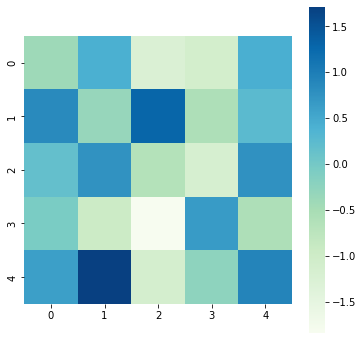

(25,)
[-0.40393116  0.41866948 -1.24894686 -1.09414291  0.42551724  0.83743202
 -0.33832266  1.28881752 -0.5816188   0.25269169  0.16045819  0.74468353
 -0.65641941 -1.16907094  0.76598058 -0.05580788 -0.96643905 -1.84051012
  0.65087261 -0.59054931  0.61009529  1.71075704 -1.12494366 -0.25223065
  0.91998543]


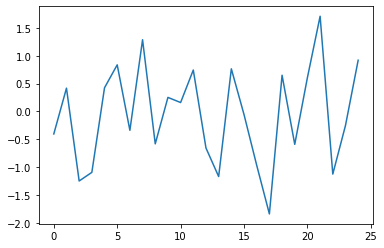

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def flatten(W):
    v = np.empty(W.shape[0]*W.shape[1])
    indx = -1
    for i in range(W.shape[0]):
        for j in range (W.shape[1]):
            indx = indx + 1
            # index = i*W.shape[0] + j
            v[indx] = W[i][j]
    # v = ... # Exercise 12, please convert a 5 x 5 matrix to a 25 vector
    return v

#create a random numpy matrix
W = np.random.randn(5, 5)            # (5 x 5)

f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(W, annot=False, fmt='.1f', square=True, cmap="GnBu")
plt.show()

v = flatten(W)

# v = np.c_[W, np.ones(5)]
print(v.shape)
print(v)

plt.plot(v)
plt.show()

<span style="color:SteelBlue"> Exercise finale</span> : Our first model

In [66]:
import numpy as np

# def flatten(X):
#     X_flat = ...                                 # Flatten: (N x 28 x 28) -> (N x 784)
#     # output = np.c_[X_flat, np.ones(len(X))]       # Append 1: (N x 784) -> (N x 785)
#     return output        

# data = np.load('mnist.npz')
# Xtrain = flatten(data['train_x'])             # (60000 x 785)
# Ytrain = data['train_y']                      # (60000)

def flatten(W): #applicable to tensors
    v = np.empty(shape=(W.shape[0],W.shape[1]*W.shape[2])) # 
    for k in range (W.shape[0]):
        indx = -1
        for i in range(W.shape[1]):
            for j in range (W.shape[2]):
                indx = indx + 1
                v[k][indx] = W[k][i][j]
    # v = ... # Exercise 12, please convert a 5 x 5 matrix to a 25 vector
    return v
# train_small (6000, 28, 28)

Xtrain = flatten(train_small)                   # (6000 x 784)
Ytrain = label_small                   # (6000)

Xtest = flatten(data['test_x'])               # (10000 x 785)
Ytest = data['test_y']                        # (10000)


In [ ]:
def dot_product(W,a):
    # print(W.shape)
    # print(a.shape)
    assert W.shape[-1] == a.shape[0]
    # dot = []

    shape0 = W.shape[0]
    shape1 = W.shape[1]
    dot_np = np.empty(shape0)

    # print(dot_np)

    for i in range(shape0):
        # dot_i = 0
        dot_np[i] = 0
        for j in range(shape1):
            # dot_i = dot_i + W[i][j]*a[j]
            dot_np[i] += W[i][j]*a[j]
        # dot.append(dot_i)
    return dot_np

W = np.random.randn(10, 28*28)            # (10 x 784), initial weights

eta = 0.001
for t in range(100):
    
    # Structured perceptron for updating weights.
    num_correct_train = 0
    for x, y in zip(Xtrain, Ytrain):
        dot = dot_product(W,x)                  # substitute your dot product function / remplacez par votre fonction de produit scalaire
        y_pred = argmax(dot)                    # substitute your argmax / remplacez par votre argmax
        
        if y_pred != y:
            continue
            # W[y] += ...                         # we need to increase the dot product... How can we do this? / 
                                                # nous devons augmenter le produit scalaire... Comment pouvons-nous faire cela ?
            # W[y_pred] -= ...                    # we need to decreases the dot product... How can we do this? / 
                                                # nous devons diminuer le produit scalaire... Comment pouvons-nous faire cela ?
        else:
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        dot = dot_product(W,x)   
        y_pred = argmax(dot)
        if y_pred == y:
            num_correct_test += 1
    
    print('#{}: train_accuracy={:.4f}, test_accuracy={:.4f}'.format(
        t,
        float(num_correct_train) / len(Ytrain),
        float(num_correct_test) / len(Ytest)
    ))

(10, 784)
(784,)
[15.18670973  4.2052966  12.89770358  3.44932494  4.24779292 15.13798528
 14.66192798  0.965022    8.24359094  6.02538755]


<span style="color:SteelBlue"> Questions</span> : 
- Can you demonstrate that the dot product of a vector with itself is always positive (non-negative)? / Pouvez-vous démontrer que le produit scalaire d'un vecteur avec lui-même est toujours positif (non négatif)
- We have only coded a model y = wx. Can you modify the code for a model y = wx + b? / Nous avons seulement codé un modèle y = wx. Pouvez-vous modifier le code d'un modèle y = wx + b ?
- How does the model perform on 'hard' test examples? / Comment le modèle fonctionne-t-il sur des exemples de tests « durs » ?